In [2]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import sys
import os
# local libraries
sys.path.append(os.path.abspath(os.path.join(sys.path[0], '..', 'src', 'lib')))
import athena_connect

pd.options.display.max_rows = 50
pd.options.display.max_columns = 100
pd.options.mode.chained_assignment = None
%matplotlib inline

### Data and Features

In [1]:
features_sql = """WITH target_trxeth AS (
  SELECT coin_partition
    , DATE(from_unixtime(cast(close_timestamp AS BIGINT) / 1000)) AS trade_date
    , from_unixtime(cast(close_timestamp AS BIGINT) / 1000) AS trade_datetime
    , (CAST(close_timestamp AS BIGINT) / 1000 / 60) AS trade_minute
    , CAST(open AS DOUBLE) AS open, CAST(high AS DOUBLE) AS high, CAST(low AS DOUBLE) AS low, CAST(close AS DOUBLE) AS close
    , CAST(volume AS DOUBLE) AS volume, CAST(quote_asset_volume AS DOUBLE) AS quote_asset_volume, CAST(trade_count AS BIGINT) AS trade_count
    , CAST(taker_buy_base_asset_volume AS DOUBLE) as tbbav, CAST(taker_buy_quote_asset_volume AS DOUBLE) as tbqav
  FROM binance.historic_candlesticks 
  WHERE coin_partition = 'trxeth'
),
alt_ethbtc AS (
  SELECT coin_partition AS ethbtc_coin_partition
    , DATE(from_unixtime(cast(close_timestamp AS BIGINT) / 1000)) AS ethbtc_trade_date
    , (CAST(close_timestamp AS BIGINT) / 1000 / 60) AS ethbtc_trade_minute
    , CAST(open AS DOUBLE) AS ethbtc_open, CAST(high AS DOUBLE) AS ethbtc_high, CAST(low AS DOUBLE) AS ethbtc_low
    , CAST(close AS DOUBLE) AS ethbtc_close, CAST(volume AS DOUBLE) AS ethbtc_volume
    , CAST(quote_asset_volume AS DOUBLE) AS ethbtc_quote_asset_volume, CAST(trade_count AS BIGINT) AS ethbtc_trade_count
    , CAST(taker_buy_base_asset_volume AS DOUBLE) AS ethbtc_tbbav, CAST(taker_buy_quote_asset_volume AS DOUBLE) AS ethbtc_tbqav
  FROM binance.historic_candlesticks 
  WHERE coin_partition = 'ethbtc'
),
through_ethusdt AS (
  SELECT coin_partition AS ethusdt_coin_partition
    , DATE(from_unixtime(cast(close_timestamp AS BIGINT) / 1000)) AS ethusdt_trade_date
    , (CAST(close_timestamp AS BIGINT) / 1000 / 60) AS ethusdt_trade_minute
    , CAST(open AS DOUBLE) AS ethusdt_open, CAST(high AS DOUBLE) AS ethusdt_high, CAST(low AS DOUBLE) AS ethusdt_low
    , CAST(close AS DOUBLE) AS ethusdt_close, CAST(volume AS DOUBLE) AS ethusdt_volume
    , CAST(quote_asset_volume AS DOUBLE) AS ethusdt_quote_asset_volume, CAST(trade_count AS BIGINT) AS ethusdt_trade_count
    , CAST(taker_buy_base_asset_volume AS DOUBLE) AS ethusdt_tbbav, CAST(taker_buy_quote_asset_volume AS DOUBLE) AS ethusdt_tbqav
  FROM binance.historic_candlesticks 
  WHERE coin_partition = 'ethusdt'
)
SELECT trade_datetime, day_of_week(trade_datetime) as trade_day_of_week, hour(trade_datetime) as trade_hour
-- Target Features
 , open, high, low, close, volume, quote_asset_volume, trade_count, tbbav, tbqav
-- Alt Features
 , ethbtc_open, ethbtc_high, ethbtc_low, ethbtc_close, ethbtc_volume
 , ethbtc_quote_asset_volume, ethbtc_trade_count, ethbtc_tbbav, ethbtc_tbqav
-- Through Features
 , ethusdt_open, ethusdt_high, ethusdt_low, close, ethusdt_volume
 , ethusdt_quote_asset_volume, ethusdt_trade_count, ethusdt_tbbav, ethusdt_tbqav
FROM target_trxeth 
LEFT JOIN alt_ethbtc ON target_trxeth.trade_minute = alt_ethbtc.ethbtc_trade_minute
LEFT JOIN through_ethusdt ON target_trxeth.trade_minute = through_ethusdt.ethusdt_trade_minute
ORDER BY trade_minute ASC"""

In [32]:
new_features_sql = """WITH target_trxeth AS (
  SELECT coin_partition
    , DATE(from_unixtime(cast(close_timestamp AS BIGINT) / 1000)) AS trade_date
    , from_unixtime(cast(close_timestamp AS BIGINT) / 1000) AS trade_datetime
    , (CAST(close_timestamp AS BIGINT) / 1000 / 60) AS trade_minute
    , CAST(open AS DOUBLE) AS open, CAST(high AS DOUBLE) AS high, CAST(low AS DOUBLE) AS low, CAST(close AS DOUBLE) AS close
    , CAST(volume AS DOUBLE) AS volume, CAST(quote_asset_volume AS DOUBLE) AS quote_asset_volume, CAST(trade_count AS BIGINT) AS trade_count
    , CAST(taker_buy_base_asset_volume AS DOUBLE) as tbbav, CAST(taker_buy_quote_asset_volume AS DOUBLE) as tbqav
  FROM binance.historic_candlesticks 
  WHERE coin_partition = 'trxeth'
),
alt_ethbtc AS (
  SELECT coin_partition AS ethbtc_coin_partition
    , DATE(from_unixtime(cast(close_timestamp AS BIGINT) / 1000)) AS ethbtc_trade_date
    , (CAST(close_timestamp AS BIGINT) / 1000 / 60) AS ethbtc_trade_minute
    , CAST(open AS DOUBLE) AS ethbtc_open, CAST(high AS DOUBLE) AS ethbtc_high, CAST(low AS DOUBLE) AS ethbtc_low
    , CAST(close AS DOUBLE) AS ethbtc_close, CAST(volume AS DOUBLE) AS ethbtc_volume
    , CAST(quote_asset_volume AS DOUBLE) AS ethbtc_quote_asset_volume, CAST(trade_count AS BIGINT) AS ethbtc_trade_count
    , CAST(taker_buy_base_asset_volume AS DOUBLE) AS ethbtc_tbbav, CAST(taker_buy_quote_asset_volume AS DOUBLE) AS ethbtc_tbqav
  FROM binance.historic_candlesticks 
  WHERE coin_partition = 'ethbtc'
),
through_ethusdt AS (
  SELECT coin_partition AS ethusdt_coin_partition
    , DATE(from_unixtime(cast(close_timestamp AS BIGINT) / 1000)) AS ethusdt_trade_date
    , (CAST(close_timestamp AS BIGINT) / 1000 / 60) AS ethusdt_trade_minute
    , CAST(open AS DOUBLE) AS ethusdt_open, CAST(high AS DOUBLE) AS ethusdt_high, CAST(low AS DOUBLE) AS ethusdt_low
    , CAST(close AS DOUBLE) AS ethusdt_close, CAST(volume AS DOUBLE) AS ethusdt_volume
    , CAST(quote_asset_volume AS DOUBLE) AS ethusdt_quote_asset_volume, CAST(trade_count AS BIGINT) AS ethusdt_trade_count
    , CAST(taker_buy_base_asset_volume AS DOUBLE) AS ethusdt_tbbav, CAST(taker_buy_quote_asset_volume AS DOUBLE) AS ethusdt_tbqav
  FROM binance.historic_candlesticks 
  WHERE coin_partition = 'ethusdt'
)
SELECT trade_datetime, day_of_week(trade_datetime) as trade_day_of_week, hour(trade_datetime) as trade_hour
-- Target Features
 , open, high, low, close, volume, quote_asset_volume, trade_count, tbbav, tbqav
-- Alt Features
 , ethbtc_open, ethbtc_high, ethbtc_low, ethbtc_close, ethbtc_volume
 , ethbtc_quote_asset_volume, ethbtc_trade_count, ethbtc_tbbav, ethbtc_tbqav
-- Through Features
 , ethusdt_open, ethusdt_high, ethusdt_low, close, ethusdt_volume
 , ethusdt_quote_asset_volume, ethusdt_trade_count, ethusdt_tbbav, ethusdt_tbqav
-- LAG Features
 ,((open - LEAD(open) OVER (ORDER BY trade_minute DESC)) / LEAD(open) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_1_open_perc_chg
 ,((LEAD(open) OVER (ORDER BY trade_minute DESC) - LEAD(open, 2) OVER (ORDER BY trade_minute DESC)) / LEAD(open, 2) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_2_3_open_perc_chg
 ,((LEAD(open) OVER (ORDER BY trade_minute DESC) - LEAD(open, 3) OVER (ORDER BY trade_minute DESC)) / LEAD(open, 3) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_3_4_open_perc_chg
 ,((LEAD(open) OVER (ORDER BY trade_minute DESC) - LEAD(open, 4) OVER (ORDER BY trade_minute DESC)) / LEAD(open, 4) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_4_5_open_perc_chg
 ,((open - LEAD(open, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(open, 5) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_5_open_perc_chg
 ,((open - LEAD(open, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(open, 10) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_10_open_perc_chg
 ,(((open - LEAD(open) OVER (ORDER BY trade_minute DESC)) / LEAD(open) OVER (ORDER BY trade_minute DESC)) * 100) -
   (((open - LEAD(open, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(open, 5) OVER (ORDER BY trade_minute DESC)) * 100) AS prev_5_open_rate_chg
 ,(((open - LEAD(open) OVER (ORDER BY trade_minute DESC)) / LEAD(open) OVER (ORDER BY trade_minute DESC)) * 100) -
   (((open - LEAD(open, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(open, 10) OVER (ORDER BY trade_minute DESC)) * 100) AS prev_10_open_rate_chg
 ,((high - LEAD(high, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(high, 5) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_5_high_perc_chg
 ,((high - LEAD(high, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(high, 10) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_10_high_perc_chg
 ,((low - LEAD(low, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(low, 5) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_5_low_perc_chg
 ,((low - LEAD(low, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(low, 10) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_10_low_perc_chg
 ,COALESCE(TRY(((volume - LEAD(volume, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(volume, 5) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_5_volume_perc_chg
 ,COALESCE(TRY(((volume - LEAD(volume, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(volume, 10) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_10_volume_perc_chg 
 ,COALESCE(TRY(((quote_asset_volume - LEAD(quote_asset_volume, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(quote_asset_volume, 5) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_5_qav_perc_chg
 ,COALESCE(TRY(((quote_asset_volume - LEAD(quote_asset_volume, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(quote_asset_volume, 10) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_10_qav_perc_chg
 ,COALESCE(TRY(((trade_count - LEAD(trade_count, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(trade_count, 5) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_5_trade_count_perc_chg
 ,COALESCE(TRY(((trade_count - LEAD(trade_count, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(trade_count, 10) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_10_trade_count_perc_chg 
,COALESCE(TRY(((tbbav - LEAD(tbbav, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(tbbav, 5) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_5_tbbav_perc_chg
 ,COALESCE(TRY(((tbbav - LEAD(tbbav, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(tbbav, 10) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_10_tbbav_perc_chg 
 ,COALESCE(TRY(((tbqav - LEAD(tbqav, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(tbqav, 5) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_5_tbqav_perc_chg
 ,COALESCE(TRY(((tbqav - LEAD(tbqav, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(tbqav, 10) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_10_tbqav_perc_chg 

-- LAG Alt Features
 ,((ethbtc_open - LEAD(ethbtc_open) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_open) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_1_open_perc_chg
 ,((ethbtc_open - LEAD(ethbtc_open, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_open, 5) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_5_ethbtc_open_perc_chg
 ,((ethbtc_open - LEAD(ethbtc_open, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_open, 10) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_10_ethbtc_open_perc_chg
 ,(((ethbtc_open - LEAD(ethbtc_open) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_open) OVER (ORDER BY trade_minute DESC)) * 100) -
   (((ethbtc_open - LEAD(ethbtc_open, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_open, 5) OVER (ORDER BY trade_minute DESC)) * 100) AS prev_5_ethbtc_open_rate_chg
 ,(((ethbtc_open - LEAD(ethbtc_open) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_open) OVER (ORDER BY trade_minute DESC)) * 100) -
   (((ethbtc_open - LEAD(ethbtc_open, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_open, 10) OVER (ORDER BY trade_minute DESC)) * 100) AS prev_10_open_rate_chg   
 ,((ethbtc_high - LEAD(ethbtc_high, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_high, 5) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_5_ethbtc_high_perc_chg
 ,((ethbtc_high - LEAD(ethbtc_high, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_high, 10) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_10_high_perc_chg
 ,((ethbtc_low - LEAD(ethbtc_low, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_low, 5) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_5_ethbtc_low_perc_chg
 ,((ethbtc_low - LEAD(ethbtc_low, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_low, 10) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_10_ethbtc_low_perc_chg   
 ,COALESCE(TRY(((ethbtc_volume - LEAD(ethbtc_volume, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_volume, 5) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_5_ethbtc_volume_perc_chg
 ,COALESCE(TRY(((ethbtc_volume - LEAD(ethbtc_volume, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_volume, 10) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_10_ethbtc_volume_perc_chg 
 ,COALESCE(TRY(((ethbtc_quote_asset_volume - LEAD(ethbtc_quote_asset_volume, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_quote_asset_volume, 5) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_5_ethbtc_qav_perc_chg
 ,COALESCE(TRY(((ethbtc_quote_asset_volume - LEAD(ethbtc_quote_asset_volume, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_quote_asset_volume, 10) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_10_ethbtc_qav_perc_chg 
 ,COALESCE(TRY(((ethbtc_trade_count - LEAD(ethbtc_trade_count, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_trade_count, 5) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_5_ethbtc_trade_count_perc_chg
 ,COALESCE(TRY(((ethbtc_trade_count - LEAD(ethbtc_trade_count, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_trade_count, 10) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_10_ethbtc_trade_count_perc_chg 
 ,COALESCE(TRY(((ethbtc_tbbav - LEAD(ethbtc_tbbav, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_tbbav, 5) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_5_ethbtc_tbbav_perc_chg
 ,COALESCE(TRY(((ethbtc_tbbav - LEAD(ethbtc_tbbav, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_tbbav, 10) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_10_ethbtc_tbbav_perc_chg 
 ,COALESCE(TRY(((ethbtc_tbqav - LEAD(ethbtc_tbqav, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_tbqav, 5) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_5_ethbtc_tbqav_perc_chg
 ,COALESCE(TRY(((ethbtc_tbqav - LEAD(ethbtc_tbqav, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(ethbtc_tbqav, 10) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_10_ethbtc_tbqav_perc_chg 
 -- LAG Through Features
 ,((ethusdt_open - LEAD(ethusdt_open) OVER (ORDER BY trade_minute DESC)) / LEAD(open) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_1_open_perc_chg
 ,((ethusdt_open - LEAD(ethusdt_open, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_open, 5) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_5_ethusdt_open_perc_chg
 ,((ethusdt_open - LEAD(ethusdt_open, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_open, 10) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_10_ethusdt_open_perc_chg
 ,(((ethusdt_open - LEAD(ethusdt_open) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_open) OVER (ORDER BY trade_minute DESC)) * 100) -
   (((ethusdt_open - LEAD(ethusdt_open, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_open, 5) OVER (ORDER BY trade_minute DESC)) * 100) AS prev_5_ethusdt_open_rate_chg
 ,(((ethusdt_open - LEAD(ethusdt_open) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_open) OVER (ORDER BY trade_minute DESC)) * 100) -
   (((ethusdt_open - LEAD(ethusdt_open, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_open, 10) OVER (ORDER BY trade_minute DESC)) * 100) AS prev_10_ethusdt_open_rate_chg  
 ,((ethusdt_high - LEAD(ethusdt_high, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_high, 5) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_5_ethusdt_high_perc_chg
 ,((ethusdt_high - LEAD(ethusdt_high, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_high, 10) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_10_ethusdt_high_perc_chg 
 ,((ethusdt_low - LEAD(ethusdt_low, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_low, 5) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_5_ethusdt_low_perc_chg
 ,((ethusdt_low - LEAD(ethusdt_low, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_low, 10) OVER (ORDER BY trade_minute DESC)) * 100 AS prev_10_ethusdt_low_perc_chg  
 ,COALESCE(TRY(((ethusdt_volume - LEAD(ethusdt_volume, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_volume, 5) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_5_ethusdt_volume_perc_chg
 ,COALESCE(TRY(((ethusdt_volume - LEAD(ethusdt_volume, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_volume, 10) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_10_ethusdt_volume_perc_chg
 ,COALESCE(TRY(((ethusdt_quote_asset_volume - LEAD(ethusdt_quote_asset_volume, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_quote_asset_volume, 5) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_5_ethusdt_qav_perc_chg
 ,COALESCE(TRY(((ethusdt_quote_asset_volume - LEAD(ethusdt_quote_asset_volume, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_quote_asset_volume, 10) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_10_ethusdt_qav_perc_chg
 ,COALESCE(TRY(((ethusdt_trade_count - LEAD(ethusdt_trade_count, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_trade_count, 5) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_5_ethusdt_trade_count_perc_chg
 ,COALESCE(TRY(((ethusdt_trade_count - LEAD(ethusdt_trade_count, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_trade_count, 10) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_10_ethusdt_trade_count_perc_chg
 ,COALESCE(TRY(((ethusdt_tbbav - LEAD(ethusdt_tbbav, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_tbbav, 5) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_5_ethusdt_tbbav_perc_chg
 ,COALESCE(TRY(((ethusdt_tbbav - LEAD(ethusdt_tbbav, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_tbbav, 10) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_10_ethusdt_tbbav_perc_chg
 ,COALESCE(TRY(((ethusdt_tbqav - LEAD(ethusdt_tbqav, 5) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_tbqav, 5) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_5_ethusdt_tbqav_perc_chg
 ,COALESCE(TRY(((ethusdt_tbqav - LEAD(ethusdt_tbqav, 10) OVER (ORDER BY trade_minute DESC)) / LEAD(ethusdt_tbqav, 10) OVER (ORDER BY trade_minute DESC)) * 100),0) AS prev_10_ethusdt_tbqav_perc_chg
  -- Target Variables
 ,((LAG(open) OVER (ORDER BY trade_minute DESC) - open) / open) * 100 AS futr_1_open_perc_chg
 ,((LAG(open, 5) OVER (ORDER BY trade_minute DESC) - open) / open) * 100 AS futr_5_open_perc_chg
 ,((LAG(open, 10) OVER (ORDER BY trade_minute DESC) - open) / open) * 100 AS futr_10_open_perc_chg 
FROM target_trxeth 
LEFT JOIN alt_ethbtc ON target_trxeth.trade_minute = alt_ethbtc.ethbtc_trade_minute
LEFT JOIN through_ethusdt ON target_trxeth.trade_minute = through_ethusdt.ethusdt_trade_minute
ORDER BY trade_minute ASC"""

In [3]:
athena = athena_connect.Athena()
features_df = athena.pandas_read_athena(features_sql)
features_df.fillna(0, inplace=True)
print(features_df.shape)
features_df.head(20)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): athena.us-east-1.amazonaws.com
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): loidsig-crypto.s3.amazonaws.com


(274579, 30)


,trade_datetime,trade_day_of_week,trade_hour,open,high,low,close,volume,quote_asset_volume,trade_count,tbbav,tbqav,ethbtc_open,ethbtc_high,ethbtc_low,ethbtc_close,ethbtc_volume,ethbtc_quote_asset_volume,ethbtc_trade_count,ethbtc_tbbav,ethbtc_tbqav,ethusdt_open,ethusdt_high,ethusdt_low,close.1,ethusdt_volume,ethusdt_quote_asset_volume,ethusdt_trade_count,ethusdt_tbbav,ethusdt_tbqav
0,2018-01-01 00:00:59.000,1,0,0.000059,0.000059,0.000059,0.000059,891404.0,52.918951,48,821249.0,48.753948,0.053586,0.053613,0.053496,0.053520,162.312,8.691875,276,102.213,5.475718,733.01,733.97,732.75,0.000059,19.77247,14490.961596,29,1.74674,1281.803635
1,2018-01-01 00:01:59.000,1,0,0.000059,0.000059,0.000059,0.000059,914132.0,54.276705,61,763155.0,45.313666,0.053522,0.053599,0.053522,0.053580,194.671,10.425546,171,36.347,1.947037,733.34,734.52,732.51,0.000059,26.05199,19105.098094,50,21.31950,15638.007363
2,2018-01-01 00:02:59.000,1,0,0.000059,0.000059,0.000059,0.000059,1484245.0,88.021694,88,667734.0,39.620120,0.053580,0.053580,0.053474,0.053579,228.432,12.231527,324,89.497,4.793154,732.51,734.49,732.49,0.000059,15.71883,11515.440038,40,3.12611,2291.043904
3,2018-01-01 00:03:59.000,1,0,0.000059,0.000059,0.000059,0.000059,2265403.0,133.662586,153,839866.0,49.549253,0.053579,0.053598,0.053519,0.053529,249.478,13.359549,277,125.317,6.713129,732.51,733.83,730.00,0.000059,29.43683,21532.608268,59,3.50540,2567.132006
4,2018-01-01 00:04:59.000,1,0,0.000059,0.000059,0.000059,0.000059,1559752.0,91.521474,86,1250671.0,73.409699,0.053558,0.053640,0.053530,0.053621,256.474,13.745835,328,153.115,8.208092,730.36,731.00,728.93,0.000059,42.50766,31036.170949,103,17.01968,12429.254412
5,2018-01-01 00:05:59.000,1,0,0.000059,0.000059,0.000059,0.000059,556238.0,32.879063,74,286506.0,16.952315,0.053573,0.053654,0.053567,0.053588,194.333,10.415969,240,71.760,3.848222,728.50,729.80,727.11,0.000059,12.01907,8755.309915,50,6.13528,4470.488783
6,2018-01-01 00:06:59.000,1,0,0.000059,0.000059,0.000059,0.000059,1166607.0,68.832956,51,848197.0,50.059833,0.053585,0.053686,0.053585,0.053602,235.860,12.649419,280,89.100,4.779705,727.99,727.99,725.00,0.000059,20.87418,15146.878732,28,0.78926,574.523387
7,2018-01-01 00:07:59.000,1,0,0.000059,0.000059,0.000059,0.000059,373332.0,22.048151,39,254043.0,15.007745,0.053603,0.053690,0.053597,0.053638,153.643,8.242128,214,67.401,3.617433,727.31,727.42,725.00,0.000059,33.23205,24105.332157,76,16.11456,11690.025960
8,2018-01-01 00:08:59.000,1,0,0.000059,0.000059,0.000059,0.000059,1154747.0,68.030570,61,809267.0,47.681706,0.053638,0.053697,0.053585,0.053692,211.891,11.367717,257,124.944,6.705672,725.09,727.17,724.43,0.000059,24.53052,17803.658721,47,20.40186,14807.272517
9,2018-01-01 00:09:59.000,1,0,0.000059,0.000059,0.000059,0.000059,1656055.0,97.876335,114,1534539.0,90.699753,0.053691,0.053720,0.053613,0.053718,158.959,8.529168,251,116.857,6.271343,727.08,727.25,725.16,0.000059,44.26183,32140.691661,62,39.02668,28341.730750


### vector autoregression

In [5]:
# some example data
import numpy as np
import pandas
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR
mdata = sm.datasets.macrodata.load_pandas().data
mdata

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
5,1960.0,2.0,2834.390,1792.9,298.152,460.400,1966.1,29.550,140.2,2.68,5.2,180.671,0.14,2.55
6,1960.0,3.0,2839.022,1785.8,296.375,474.676,1967.8,29.750,140.9,2.36,5.6,181.528,2.70,-0.34
7,1960.0,4.0,2802.616,1788.2,259.764,476.434,1966.6,29.840,141.1,2.29,6.3,182.287,1.21,1.08
8,1961.0,1.0,2819.264,1787.7,266.405,475.854,1984.5,29.810,142.1,2.37,6.8,182.992,-0.40,2.77
9,1961.0,2.0,2872.005,1814.3,286.246,480.328,2014.4,29.920,142.9,2.29,7.0,183.691,1.47,0.81


In [6]:
 # prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]

from statsmodels.tsa.base.datetools import dates_from_str
quarterly = dates_from_str(quarterly)
mdata = mdata[['realgdp','realcons','realinv']]

mdata.index = pandas.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()
data

,realgdp,realcons,realinv
1959-06-30,0.024942,0.015286,0.080213
1959-09-30,-0.001193,0.010386,-0.072131
1959-12-31,0.003495,0.001084,0.034425
1960-03-31,0.022190,0.009534,0.102664
1960-06-30,-0.004685,0.012572,-0.106694
1960-09-30,0.001633,-0.003968,-0.005978
1960-12-31,-0.012906,0.001343,-0.131852
1961-03-31,0.005923,-0.000280,0.025244
1961-06-30,0.018535,0.014770,0.071834
1961-09-30,0.016032,0.004839,0.080453


In [7]:
 # make a VAR model
model = VAR(data)
model

In [13]:
train_df = features_df[-57000:-1450] #  weeks train
test_df = features_df[-1440:-10] # one day test


In [14]:
train_df

,coin_partition,trade_date,ds,trade_minute,trade_count,avg_price,avg_qty,avg_5_min_price,avg_5_min_qty,avg_5_min_trade_count,prev_min_perc_chg,prev_2_3_min_perc_chg,prev_3_4_min_perc_chg,prev_4_5_min_perc_chg,prev_5_min_perc_chg,prev_10_min_perc_chg,prev_5_min_rate_chg,prev_10_min_rate_chg,alt_prev_min_perc_chg,alt_prev_5_min_perc_chg,alt_prev_5_min_rate_chg,alt_prev_10_min_rate_chg,futr_min_perc_chg,futr_5_min_perc_chg,y
125693,trxeth,2018-03-31,2018-03-31 09:34:58.000,25374814,78,0.000093,5717.474359,0.000094,6081.915531,34.000000,-0.312622,-0.073230,-0.297585,-0.302883,-0.873425,-0.207135,0.560803,-0.105486,-0.004081,-0.022629,0.018548,-0.353974,0.003616,0.081663,-0.216686
125694,trxeth,2018-03-31,2018-03-31 09:35:58.000,25374815,38,0.000093,4554.368421,0.000093,6338.310268,35.833333,0.003616,-0.312622,-0.073230,-0.297585,-0.979298,-0.364589,0.982913,0.368205,-0.108685,-0.143062,0.034377,-0.313537,0.093435,-0.721627,-0.411452
125695,trxeth,2018-03-31,2018-03-31 09:36:59.000,25374816,48,0.000093,13166.500000,0.000093,7549.446233,37.500000,0.093435,0.003616,-0.312622,-0.073230,-0.585668,-0.277784,0.679104,0.371219,0.285731,0.030925,0.254805,-0.133461,0.124342,-0.737056,-0.756289
125696,trxeth,2018-03-31,2018-03-31 09:37:53.000,25374817,33,0.000093,6193.181818,0.000093,6702.968202,39.666667,0.124342,0.093435,0.003616,-0.312622,-0.164961,-0.143906,0.289302,0.268248,0.523965,0.551219,-0.027254,-0.452794,0.080785,-0.999774,-0.979000
125697,trxeth,2018-03-31,2018-03-31 09:38:56.000,25374818,28,0.000093,4169.250000,0.000093,6239.195766,40.000000,0.080785,0.124342,0.093435,0.003616,-0.011087,-0.277951,0.091872,0.358737,-0.038901,0.658345,-0.697246,-0.655278,-0.220152,-0.881134,-1.384200
125698,trxeth,2018-03-31,2018-03-31 09:39:51.000,25374819,20,0.000093,8248.950000,0.000093,7008.287433,40.833333,-0.220152,0.080785,0.124342,0.093435,0.081663,-0.792475,-0.301815,0.572323,0.050037,0.712821,-0.662784,-0.639994,-0.799048,-0.298105,-1.461373
125699,trxeth,2018-03-31,2018-03-31 09:40:59.000,25374820,94,0.000092,9745.840426,0.000093,7679.681777,43.500000,-0.799048,-0.220152,0.080785,0.124342,-0.721627,-1.693858,-0.077421,0.894810,0.103405,0.926655,-0.823250,-0.678863,0.077880,0.312429,-0.583536
125700,trxeth,2018-03-31,2018-03-31 09:41:59.000,25374821,103,0.000093,5614.660194,0.000093,7856.397073,54.333333,0.077880,-0.799048,-0.220152,0.080785,-0.737056,-1.318408,0.814935,1.396287,-0.162460,0.475600,-0.638060,-0.669132,-0.140656,-0.019376,-0.368190
125701,trxeth,2018-03-31,2018-03-31 09:42:58.000,25374822,81,0.000092,6749.888889,0.000093,6786.961888,59.833333,-0.140656,0.077880,-0.799048,-0.220152,-0.999774,-1.163085,0.859118,1.022429,-0.037670,-0.085765,0.048095,-0.502651,0.200720,0.020983,-0.288979
125702,trxeth,2018-03-31,2018-03-31 09:43:49.000,25374823,38,0.000093,6751.394737,0.000093,6879.997374,60.666667,0.200720,-0.140656,0.077880,-0.799048,-0.881134,-0.892123,1.081854,1.092843,-0.045840,-0.092701,0.046861,-0.610874,0.366765,-0.507538,-0.586416


In [15]:
test_df

,coin_partition,trade_date,ds,trade_minute,trade_count,avg_price,avg_qty,avg_5_min_price,avg_5_min_qty,avg_5_min_trade_count,prev_min_perc_chg,prev_2_3_min_perc_chg,prev_3_4_min_perc_chg,prev_4_5_min_perc_chg,prev_5_min_perc_chg,prev_10_min_perc_chg,prev_5_min_rate_chg,prev_10_min_rate_chg,alt_prev_min_perc_chg,alt_prev_5_min_perc_chg,alt_prev_5_min_rate_chg,alt_prev_10_min_rate_chg,futr_min_perc_chg,futr_5_min_perc_chg,y
181253,trxeth,2018-05-09,2018-05-09 00:00:59.000,25430400,15,0.000110,3163.000000,0.000110,5082.656746,13.500000,-0.029763,-0.130073,-0.035892,0.070809,-0.061183,0.056620,0.031420,-0.086383,-0.083157,-0.500323,0.417165,0.324383,0.048758,-0.146576,-0.260142
181254,trxeth,2018-05-09,2018-05-09 00:01:56.000,25430401,6,0.000110,3394.166667,0.000110,5114.902473,12.333333,0.048758,-0.029763,-0.130073,-0.035892,-0.076264,0.026493,0.125022,0.022265,-0.029625,-0.270214,0.240589,0.405898,-0.055521,-0.248513,-0.331095
181255,trxeth,2018-05-09,2018-05-09 00:02:56.000,25430402,19,0.000110,2978.578947,0.000110,4676.522773,14.333333,-0.055521,0.048758,-0.029763,-0.130073,-0.202409,-0.094834,0.146888,0.039313,0.188177,0.196213,-0.008036,0.424222,-0.047855,-0.214502,-0.234895
181256,trxeth,2018-05-09,2018-05-09 00:03:57.000,25430403,14,0.000110,3005.714286,0.000110,4635.600154,15.333333,-0.047855,-0.055521,0.048758,-0.029763,-0.214351,-0.219631,0.166496,0.171776,0.085682,0.088054,-0.002372,0.064253,-0.068593,-0.233329,-0.201825
181257,trxeth,2018-05-09,2018-05-09 00:04:48.000,25430404,25,0.000110,5810.200000,0.000110,5153.994599,17.500000,-0.068593,-0.047855,-0.055521,0.048758,-0.152923,-0.248866,0.084330,0.180273,-0.074736,0.086096,-0.160833,0.029509,-0.023408,-0.142529,-0.124986
181258,trxeth,2018-05-09,2018-05-09 00:05:24.000,25430405,3,0.000110,5284.333333,0.000110,3939.332206,13.666667,-0.023408,-0.068593,-0.047855,-0.055521,-0.146576,-0.207670,0.123168,0.184261,-0.069610,0.099667,-0.169277,0.331544,-0.053379,-0.113733,-0.156699
181259,trxeth,2018-05-09,2018-05-09 00:06:47.000,25430406,5,0.000110,4100.800000,0.000110,4095.632206,12.000000,-0.053379,-0.023408,-0.068593,-0.047855,-0.248513,-0.324588,0.195134,0.271209,-0.114695,0.014488,-0.129182,0.141071,-0.021444,-0.082788,-0.090515
181260,trxeth,2018-05-09,2018-05-09 00:07:53.000,25430407,9,0.000110,8580.222222,0.000110,4959.974798,12.500000,-0.021444,-0.053379,-0.023408,-0.068593,-0.214502,-0.416476,0.193058,0.395032,-0.206146,-0.379152,0.173006,-0.022463,-0.066714,-0.020437,0.292964
181261,trxeth,2018-05-09,2018-05-09 00:08:34.000,25430408,17,0.000110,8321.882353,0.000110,5850.525366,12.166667,-0.066714,-0.021444,-0.053379,-0.023408,-0.233329,-0.447180,0.166616,0.380467,-0.074955,-0.539042,0.464088,0.376509,0.022358,0.031578,0.373802
181262,trxeth,2018-05-09,2018-05-09 00:09:52.000,25430409,7,0.000110,8949.857143,0.000110,6841.215842,11.000000,0.022358,-0.066714,-0.021444,-0.053379,-0.142529,-0.295234,0.164887,0.317592,0.299701,-0.166345,0.466046,0.380093,0.005422,0.017568,0.429621


### Time Series

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/puter/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


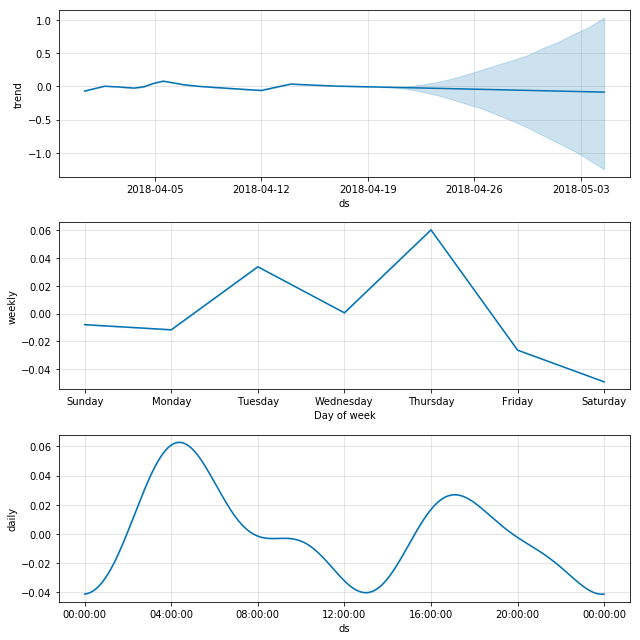

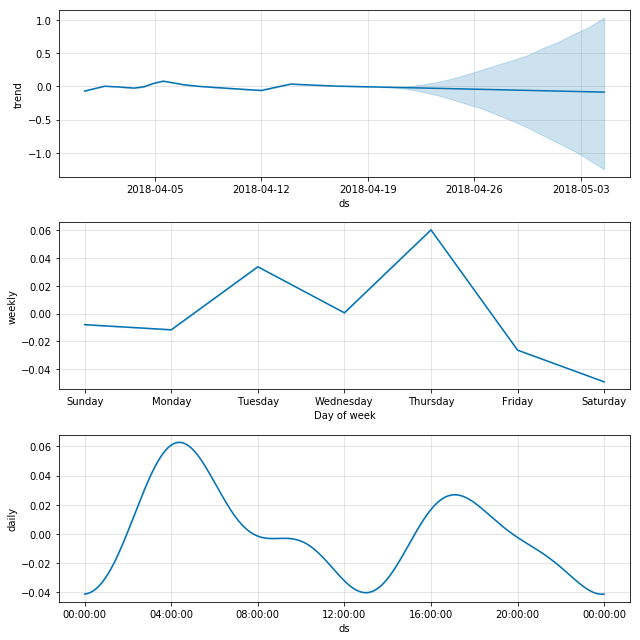

In [5]:
m = Prophet()
m.fit(train_df[['ds','y']])
future = m.make_future_dataframe(periods=14)
forecast = m.predict(future)
m.plot_components(forecast)

In [6]:
forecast

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat
0,2018-03-31 09:34:58,-0.070359,-0.070359,-0.070359,-0.892269,0.744581,-0.003388,-0.003388,-0.003388,-0.022140,-0.022140,-0.022140,-0.022140,-0.022140,-0.022140,-0.018753,-0.018753,-0.018753,-0.092499
1,2018-03-31 09:35:58,-0.070319,-0.070319,-0.070319,-0.946542,0.783236,-0.003424,-0.003424,-0.003424,-0.022133,-0.022133,-0.022133,-0.022133,-0.022133,-0.022133,-0.018709,-0.018709,-0.018709,-0.092452
2,2018-03-31 09:36:59,-0.070279,-0.070279,-0.070279,-0.912352,0.703782,-0.003463,-0.003463,-0.003463,-0.022128,-0.022128,-0.022128,-0.022128,-0.022128,-0.022128,-0.018664,-0.018664,-0.018664,-0.092407
3,2018-03-31 09:37:53,-0.070243,-0.070243,-0.070243,-0.917548,0.740150,-0.003500,-0.003500,-0.003500,-0.022125,-0.022125,-0.022125,-0.022125,-0.022125,-0.022125,-0.018625,-0.018625,-0.018625,-0.092368
4,2018-03-31 09:38:56,-0.070201,-0.070201,-0.070201,-0.916256,0.758937,-0.003545,-0.003545,-0.003545,-0.022124,-0.022124,-0.022124,-0.022124,-0.022124,-0.022124,-0.018579,-0.018579,-0.018579,-0.092326
5,2018-03-31 09:39:51,-0.070165,-0.070165,-0.070165,-0.863501,0.718506,-0.003586,-0.003586,-0.003586,-0.022126,-0.022126,-0.022126,-0.022126,-0.022126,-0.022126,-0.018540,-0.018540,-0.018540,-0.092291
6,2018-03-31 09:40:59,-0.070120,-0.070120,-0.070120,-0.889247,0.670119,-0.003640,-0.003640,-0.003640,-0.022130,-0.022130,-0.022130,-0.022130,-0.022130,-0.022130,-0.018490,-0.018490,-0.018490,-0.092250
7,2018-03-31 09:41:59,-0.070080,-0.070080,-0.070080,-0.910986,0.778620,-0.003690,-0.003690,-0.003690,-0.022137,-0.022137,-0.022137,-0.022137,-0.022137,-0.022137,-0.018447,-0.018447,-0.018447,-0.092217
8,2018-03-31 09:42:58,-0.070041,-0.070041,-0.070041,-0.999095,0.706583,-0.003742,-0.003742,-0.003742,-0.022146,-0.022146,-0.022146,-0.022146,-0.022146,-0.022146,-0.018404,-0.018404,-0.018404,-0.092187
9,2018-03-31 09:43:49,-0.070007,-0.070007,-0.070007,-0.978282,0.730609,-0.003788,-0.003788,-0.003788,-0.022156,-0.022156,-0.022156,-0.022156,-0.022156,-0.022156,-0.018367,-0.018367,-0.018367,-0.092163


### Time Series with Regressors

In [17]:
m = Prophet()
m.add_regressor('trade_count')
m.add_regressor('alt_prev_5_min_perc_chg')
m.add_regressor('avg_5_min_qty')
m.add_regressor('prev_10_min_perc_chg')
m.add_regressor('prev_5_min_rate_chg')
m.add_regressor('avg_5_min_trade_count')
m.fit(train_df[['ds','y','trade_count','alt_prev_5_min_perc_chg','avg_5_min_qty','prev_10_min_perc_chg','prev_5_min_rate_chg','avg_5_min_trade_count']])


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/puter/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


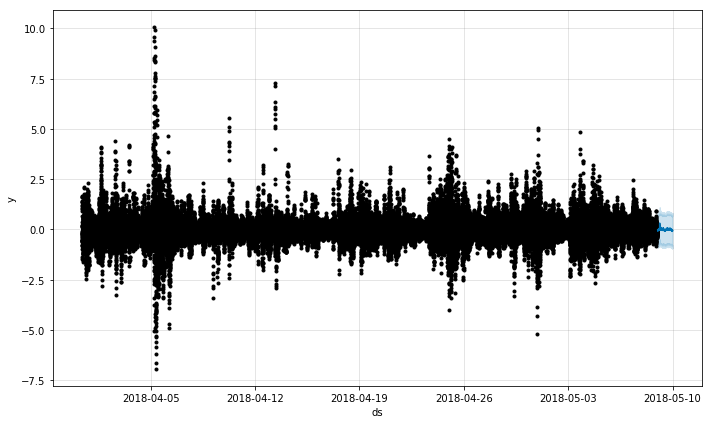

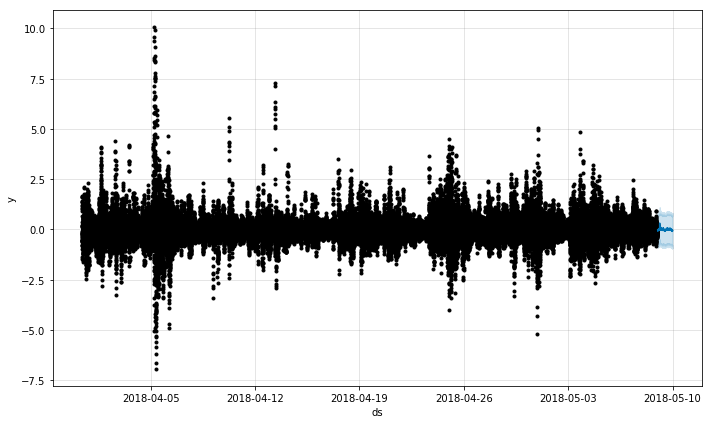

In [20]:
#future = m.make_future_dataframe(periods=300, freq='H')
fcst = m.predict(test_df[['ds','y','trade_count','alt_prev_5_min_perc_chg','avg_5_min_qty','prev_10_min_perc_chg','prev_5_min_rate_chg','avg_5_min_trade_count']])
m.plot(fcst)

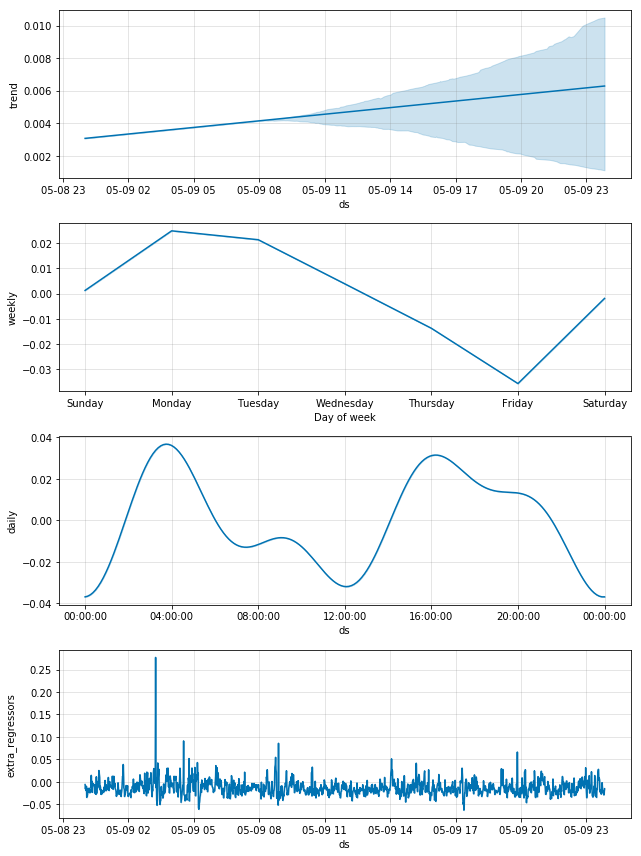

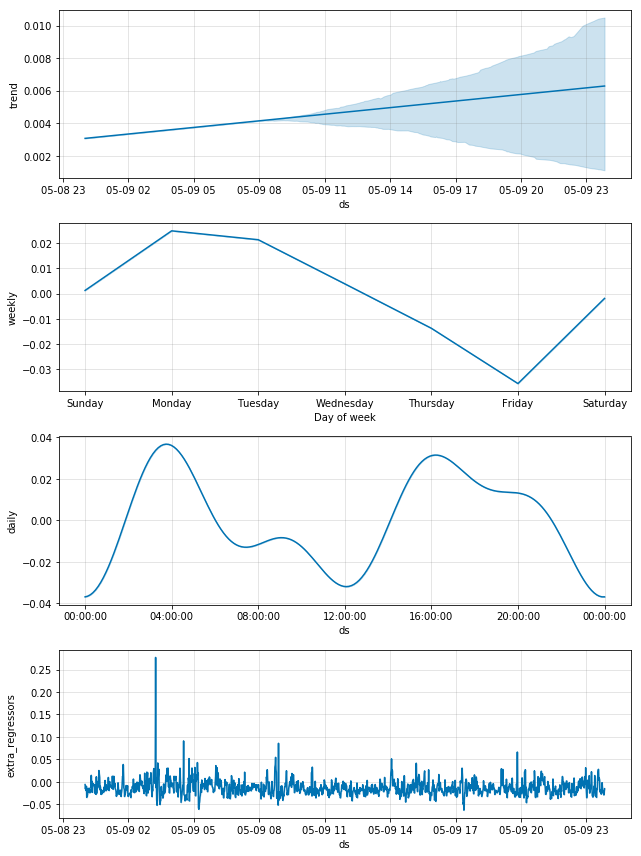

In [21]:
m.plot_components(fcst)

In [22]:
pd.options.display.max_columns = 100
fcst

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,alt_prev_5_min_perc_chg,alt_prev_5_min_perc_chg_lower,alt_prev_5_min_perc_chg_upper,avg_5_min_qty,avg_5_min_qty_lower,avg_5_min_qty_upper,avg_5_min_trade_count,avg_5_min_trade_count_lower,avg_5_min_trade_count_upper,daily,daily_lower,daily_upper,extra_regressors,extra_regressors_lower,extra_regressors_upper,prev_10_min_perc_chg,prev_10_min_perc_chg_lower,prev_10_min_perc_chg_upper,prev_5_min_rate_chg,prev_5_min_rate_chg_lower,prev_5_min_rate_chg_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,trade_count,trade_count_lower,trade_count_upper,weekly,weekly_lower,weekly_upper,yhat
0,2018-05-09 00:00:59,0.003069,0.003069,0.003069,-0.872665,0.742699,0.003830,0.003830,0.003830,-0.006950,-0.006950,-0.006950,0.009386,0.009386,0.009386,-0.036801,-0.036801,-0.036801,-0.006225,-0.006225,-0.006225,0.002003,0.002003,0.002003,0.001213,0.001213,0.001213,-0.039164,-0.039164,-0.039164,-0.032939,-0.032939,-0.032939,-0.015707,-0.015707,-0.015707,0.003862,0.003862,0.003862,-0.036095
1,2018-05-09 00:01:56,0.003071,0.003071,0.003071,-0.794699,0.711804,0.002090,0.002090,0.002090,-0.006891,-0.006891,-0.006891,0.010167,0.010167,0.010167,-0.036771,-0.036771,-0.036771,-0.016175,-0.016175,-0.016175,0.000838,0.000838,0.000838,0.004617,0.004617,0.004617,-0.049086,-0.049086,-0.049086,-0.032911,-0.032911,-0.032911,-0.026996,-0.026996,-0.026996,0.003860,0.003860,0.003860,-0.046015
2,2018-05-09 00:02:56,0.003073,0.003073,0.003073,-0.798668,0.750247,-0.001437,-0.001437,-0.001437,-0.007689,-0.007689,-0.007689,0.008828,0.008828,0.008828,-0.036733,-0.036733,-0.036733,-0.009428,-0.009428,-0.009428,-0.003853,-0.003853,-0.003853,0.005412,0.005412,0.005412,-0.042303,-0.042303,-0.042303,-0.032875,-0.032875,-0.032875,-0.010690,-0.010690,-0.010690,0.003858,0.003858,0.003858,-0.039230
3,2018-05-09 00:03:57,0.003075,0.003075,0.003075,-0.838320,0.780891,-0.000619,-0.000619,-0.000619,-0.007763,-0.007763,-0.007763,0.008159,0.008159,0.008159,-0.036688,-0.036688,-0.036688,-0.019737,-0.019737,-0.019737,-0.008678,-0.008678,-0.008678,0.006126,0.006126,0.006126,-0.052570,-0.052570,-0.052570,-0.032833,-0.032833,-0.032833,-0.016962,-0.016962,-0.016962,0.003856,0.003856,0.003856,-0.049494
4,2018-05-09 00:04:48,0.003077,0.003077,0.003077,-0.861059,0.719541,-0.000604,-0.000604,-0.000604,-0.006820,-0.006820,-0.006820,0.006709,0.006709,0.006709,-0.036646,-0.036646,-0.036646,-0.010551,-0.010551,-0.010551,-0.009809,-0.009809,-0.009809,0.003137,0.003137,0.003137,-0.043342,-0.043342,-0.043342,-0.032792,-0.032792,-0.032792,-0.003165,-0.003165,-0.003165,0.003854,0.003854,0.003854,-0.040265
5,2018-05-09 00:05:24,0.003079,0.003079,0.003079,-0.888411,0.692359,-0.000707,-0.000707,-0.000707,-0.009030,-0.009030,-0.009030,0.009275,0.009275,0.009275,-0.036613,-0.036613,-0.036613,-0.034887,-0.034887,-0.034887,-0.008216,-0.008216,-0.008216,0.004550,0.004550,0.004550,-0.067647,-0.067647,-0.067647,-0.032760,-0.032760,-0.032760,-0.030759,-0.030759,-0.030759,0.003853,0.003853,0.003853,-0.064568
6,2018-05-09 00:06:47,0.003082,0.003082,0.003082,-0.850575,0.754441,-0.000062,-0.000062,-0.000062,-0.008746,-0.008746,-0.008746,0.010390,0.010390,0.010390,-0.036528,-0.036528,-0.036528,-0.032238,-0.032238,-0.032238,-0.012736,-0.012736,-0.012736,0.007167,0.007167,0.007167,-0.064916,-0.064916,-0.064916,-0.032678,-0.032678,-0.032678,-0.028250,-0.028250,-0.028250,0.003850,0.003850,0.003850,-0.061834
7,2018-05-09 00:07:53,0.003084,0.003084,0.003084,-0.859352,0.723083,0.002914,0.002914,0.002914,-0.007173,-0.007173,-0.007173,0.010056,0.010056,0.010056,-0.036452,-0.036452,-0.036452,-0.026634,-0.026634,-0.026634,-0.016289,-0.016289,-0.016289,0.007092,0.007092,0.007092,-0.059238,-0.059238,-0.059238,-0.032604,-0.032604,-0.032604,-0.023233,-0.023233,-0.023233,0.003848,0.003848,0.003848,-0.056154
8,2018-05-09 00:08:34,0.003086,0.003086,0.003086,-0.823570,0.712936,0.004123,0.004123,0.004123,-0.005552,-0.005552,-0.005552,0.01027

In [12]:
test_df

,coin_partition,trade_date,ds,trade_minute,trade_count,avg_price,avg_qty,avg_5_min_price,avg_5_min_qty,avg_5_min_trade_count,prev_min_perc_chg,prev_2_3_min_perc_chg,prev_3_4_min_perc_chg,prev_4_5_min_perc_chg,prev_5_min_perc_chg,prev_10_min_perc_chg,prev_5_min_rate_chg,prev_10_min_rate_chg,alt_prev_min_perc_chg,alt_prev_5_min_perc_chg,alt_prev_5_min_rate_chg,alt_prev_10_min_rate_chg,futr_min_perc_chg,futr_5_min_perc_chg,y
154653,trxeth,2018-04-20,2018-04-20 12:32:59.000,25403792,9,0.000086,2397.666667,0.000086,4508.153973,13.166667,0.019704,-0.058286,0.134427,0.078182,0.184532,0.179408,-0.164829,-0.159705,-0.020731,-0.045953,0.025221,-0.313955,-0.090085,-0.026723,0.220323
154654,trxeth,2018-04-20,2018-04-20 12:33:46.000,25403793,10,0.000086,7262.600000,0.000086,4445.378973,13.500000,-0.090085,0.019704,-0.058286,0.134427,0.083796,0.114735,-0.173882,-0.204821,0.004275,-0.108151,0.112426,-0.081385,0.085014,0.040575,0.349525
154655,trxeth,2018-04-20,2018-04-20 12:34:58.000,25403794,12,0.000086,6122.583333,0.000086,5289.902121,14.000000,0.085014,-0.090085,0.019704,-0.058286,0.090629,0.257806,-0.005615,-0.172791,-0.004071,-0.155673,0.151602,-0.019560,-0.014672,0.000406,0.216216
154656,trxeth,2018-04-20,2018-04-20 12:35:39.000,25403795,15,0.000086,9759.066667,0.000086,5459.171296,11.333333,-0.014672,0.085014,-0.090085,0.019704,-0.058404,0.129821,0.043732,-0.144492,-0.150897,-0.179816,0.028920,-0.080635,-0.103587,0.064102,0.203408
154657,trxeth,2018-04-20,2018-04-20 12:36:59.000,25403796,16,0.000086,7729.062500,0.000086,6537.996528,12.500000,-0.103587,-0.014672,0.085014,-0.090085,-0.103705,0.109806,0.000119,-0.213393,-0.027571,-0.198916,0.171345,0.089477,0.096781,0.336726,0.255998
154658,trxeth,2018-04-20,2018-04-20 12:37:59.000,25403797,34,0.000086,5273.558824,0.000086,6424.089665,16.000000,0.096781,-0.103587,-0.014672,0.085014,-0.026723,0.157760,0.123504,-0.060979,0.017632,-0.160621,0.178254,0.224132,-0.022830,0.247112,0.137436
154659,trxeth,2018-04-20,2018-04-20 12:38:58.000,25403798,6,0.000086,5182.000000,0.000086,6888.145221,15.500000,-0.022830,0.096781,-0.103587,-0.014672,0.040575,0.124405,-0.063405,-0.147236,-0.023027,-0.187879,0.164852,0.272800,0.044828,0.308824,0.194102
154660,trxeth,2018-04-20,2018-04-20 12:39:58.000,25403799,19,0.000086,6670.368421,0.000086,6789.439957,17.000000,0.044828,-0.022830,0.096781,-0.103587,0.000406,0.091036,0.044421,-0.046208,-0.094598,-0.278240,0.183642,0.338882,0.049014,0.215809,0.189334
154661,trxeth,2018-04-20,2018-04-20 12:40:57.000,25403800,15,0.000086,9975.333333,0.000086,7431.564957,17.500000,0.049014,0.044828,-0.022830,0.096781,0.064102,0.005660,-0.015088,0.043354,-0.078494,-0.205929,0.127435,0.306881,0.168580,0.139217,0.146866
154662,trxeth,2018-04-20,2018-04-20 12:41:57.000,25403801,31,0.000087,6659.258065,0.000086,6914.930190,20.166667,0.168580,0.049014,0.044828,-0.022830,0.336726,0.232671,-0.168146,-0.064091,-0.192936,-0.370999,0.178063,0.376241,0.007382,-0.080457,-0.004176


In [ ]:
from sklearn.metrics import r2_score
print(f"R2: {r2_score(test_df, clf.predict(fcst))}")